In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

# A20 discharge based on RADR and MERIT-Hydro

Aims:

 * Identify MERIT-Hydro basins flowing into the Arctic Ocean
 * Merge all sub-basins to create a single watershed polygon for each MERIT-Hydro river system
 * Link MERIT-Hydro catchment IDs to the RADR dataset and estimate mean monthly discharge for each river
 * Reproject to Polar Stereographic so that Andre can link outflow locations to A20 grid cells

## 1. MERIT-Hydro spatial data

Data can be downloaded from [here](http://hydrology.princeton.edu/data/mpan/MERIT_Basins/).

### 1.1. Aggregate spatial data

The code below processes the data for each MERIT-Hydro region and merges it into a single dataset (one file for rivers and one for catchments). For each river segment, the code follows the river network downstream to find the ID of the river outlet segment. This ID is used to merge all subcatchments for each river system into a single polygon (interior holes are also removed). 

A point shapefile of catchment outlets is also created from the downstream-most point in each river system. Looking at the data in ArcGIS, it seems that all river segments are digitised *from the lowest point upstream* i.e. the **first** point in the outflow river segment is the outflow.

All datasets are reprojected to a Polar Stereographic projection with the same parameters as the A20 grid.

In [2]:
hydro_regions = [2, 3, 8, 9]

a20_proj4_str = "+proj=stere +R=6371000.0 +lat_0=90 +lat_ts=60.0 +x_0=4180000.0 +y_0=2570000.0 +lon_0=58.0"

# Output file paths
hydro_regions_str = "".join([str(i) for i in hydro_regions])
out_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_cats_{hydro_regions_str}_merged.shp"
out_riv_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_rivs_{hydro_regions_str}_merged.shp"
out_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_outlets_{hydro_regions_str}_merged.shp"

In [3]:
# Loop over regions
cat_gdf_list = []
riv_gdf_list = []
for reg in tqdm(hydro_regions, desc="Looping over regions"):
    cat_shp_path = f"~/shared/pan_arctic_data/merit_hydro_basins/cat_pfaf_{reg}_MERIT_Hydro_v07_Basins_v01.shp"
    riv_shp_path = f"~/shared/pan_arctic_data/merit_hydro_basins/riv_pfaf_{reg}_MERIT_Hydro_v07_Basins_v01.shp"
    cat_gdf = gpd.read_file(cat_shp_path)
    cat_gdf.set_index("COMID", inplace=True)
    riv_gdf = gpd.read_file(riv_shp_path)
    riv_gdf.set_index("COMID", inplace=True)

    # Get list of all river outlets for checking
    riv_outlet_ids = riv_gdf.query("NextDownID == 0").index.unique()

    # For each river segment, follow network downstream to find outflow ID
    outlet_comids = []
    for comid, row in tqdm(
        riv_gdf.iterrows(),
        total=riv_gdf.shape[0],
        desc=f"Finding downstream outlets in region {reg}",
    ):
        next_down_id = row["NextDownID"]
        while next_down_id != 0:
            comid = next_down_id
            next_down_id = riv_gdf.loc[comid, "NextDownID"]
        assert comid in riv_outlet_ids
        outlet_comids.append(comid)
    riv_gdf["OutCOMID"] = outlet_comids

    print(f"Dissolving catchments in region {reg}")
    cat_gdf = cat_gdf.join(riv_gdf["OutCOMID"])
    cat_gdf = cat_gdf.dissolve(by="OutCOMID")
    del cat_gdf["unitarea"]

    cat_gdf_list.append(cat_gdf)
    riv_gdf_list.append(riv_gdf)

print("Merging catchments")
cat_gdf = pd.concat(cat_gdf_list, axis="rows").reset_index()
riv_gdf = pd.concat(riv_gdf_list, axis="rows").reset_index()

print("Cleaning polygons")
cat_gdf = cat_gdf.explode(index_parts=False).reset_index()
cat_gdf.geometry = cat_gdf.geometry.apply(
    lambda p: nivapy.spatial.remove_polygon_holes(p)
)
cat_gdf = cat_gdf.dissolve(by="OutCOMID").reset_index()
cat_gdf = cat_gdf[["OutCOMID", "geometry"]]

# Explicitly set CRS, since it is not defined correctly in some of the raw files
cat_gdf.set_crs("epsg:4326", inplace=True)
riv_gdf.set_crs("epsg:4326", inplace=True)

print("Extracting outflow points")
pt_gdf = riv_gdf.query("NextDownID == 0").copy()

# 'boundary' gets the start and end points of the line segment as a Multipoint.
# Explode converts Multipoints to Points and the 'query' gets just the first point
pt_gdf["geometry"] = (
    pt_gdf["geometry"]
    .boundary.explode(index_parts=True)
    .reset_index()
    .query("level_1 == 0")[0]
    .values
)
pt_gdf["lon"] = pt_gdf.geometry.x
pt_gdf["lat"] = pt_gdf.geometry.y
pt_gdf = pt_gdf[["COMID", "lon", "lat", "geometry"]]
pt_gdf.rename({"COMID": "OutCOMID"}, axis="columns", inplace=True)

print("Reprojecting")
cat_gdf = cat_gdf.to_crs(a20_proj4_str)
riv_gdf = riv_gdf.to_crs(a20_proj4_str)
pt_gdf = pt_gdf.to_crs(a20_proj4_str)

# Save
print("Saving")
cat_gdf.to_file(out_cat_shp)
riv_gdf.to_file(out_riv_shp)
pt_gdf.to_file(out_pt_shp)

print("Done")

Looping over regions:   0%|          | 0/4 [00:00<?, ?it/s]

Finding downstream outlets in region 2:   0%|          | 0/393464 [00:00<?, ?it/s]

Dissolving catchments in region 2


Finding downstream outlets in region 3:   0%|          | 0/288613 [00:00<?, ?it/s]

Dissolving catchments in region 3


Finding downstream outlets in region 8:   0%|          | 0/128717 [00:00<?, ?it/s]

Dissolving catchments in region 8


Finding downstream outlets in region 9:   0%|          | 0/42246 [00:00<?, ?it/s]

Dissolving catchments in region 9
Merging catchments
Cleaning polygons
Extracting outflow points
Reprojecting
Saving


/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Done


In [4]:
# out_gpkg = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_merged_regions_{hydro_regions_str}.gpkg"
# cat_gdf.to_file(out_gpkg, layer='catchments', driver="GPKG")
# riv_gdf.to_file(out_gpkg, layer='rivers', driver="GPKG")
# pt_gdf.to_file(out_gpkg, layer='outlets', driver="GPKG")

### 1.2. Subset MERIT-Hydro basins to match RADR

The code above processes data for whole MERIT-Hydro regions, but we are interested in the RADR dataset (which just covers the Arctic). The code below gets the MERIT-Hydro outflows that are within RADR.

In [5]:
# Get RADR IDs
radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
ds = xr.open_dataset(radr_path)
radr_ids = ds["reach"].values
ds.close()

Some of the MERIT-Hydro basins in northern Asia (e.g. Kazakhstan) do not drain anywhere i.e. there are isolated river segments/systems in the middle of the continent where `NextDownID = 0`. This is either an error in MERIT-Hydro or else the these rivers must drain to sinkholes rather than the sea (which seems unlikely from a brief check of Google Maps). Either way, we do not want to include these basins as outlets, so they are filtered out in the code below based on their on lat/lon co-ordinates (I have confirmed using ArcGIS that the query used here preserves the locations of interest).

In [6]:
radr_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
radr_riv_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_rivs_merged.shp"
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"

# Subset to basins within RADR
radr_cat_gdf = cat_gdf.query("OutCOMID in @radr_ids")
radr_riv_gdf = riv_gdf.query("OutCOMID in @radr_ids")
radr_pt_gdf = pt_gdf.query("OutCOMID in @radr_ids")

# Exclude "within continent" outlets in Asia
incont_cat_ids = radr_pt_gdf.query("(lat < 63.2) and (61.4 < lon < 133)")[
    "OutCOMID"
].unique()
radr_cat_gdf = radr_cat_gdf.query("OutCOMID not in @incont_cat_ids")
radr_riv_gdf = radr_riv_gdf.query("OutCOMID not in @incont_cat_ids")
radr_pt_gdf = radr_pt_gdf.query("OutCOMID not in @incont_cat_ids")

radr_cat_gdf.to_file(radr_cat_shp)
radr_riv_gdf.to_file(radr_riv_shp)
radr_pt_gdf.to_file(radr_pt_shp)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 2. Resample RADR to monthly and subset to main outlets only

RADR includes data for lots of sub-basins, but we only need outflows to the coastline. The code above identified catchments that (i) flow to the coast and (ii) are in RADR. The code here subsets the RADR data to match (i.e. get RADR data for just those catchments that flow to the coast).

In [7]:
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_gdf = gpd.read_file(radr_pt_shp)
cat_ids = radr_pt_gdf["OutCOMID"].unique()

In [8]:
%%time

radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
radr_monthly_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1_monthly.nc"

ds = xr.open_dataset(radr_path)
ds = ds.sel(reach=cat_ids)
ds = ds.resample(time="M").mean()
ds.to_netcdf(radr_monthly_path)
ds

CPU times: user 6min 32s, sys: 11min 24s, total: 17min 56s
Wall time: 17min 57s


<xarray.Dataset>
Dimensions:    (time: 420, reach: 10658)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-31 1984-02-29 ... 2018-12-31
  * reach      (reach) float64 2.5e+07 2.5e+07 2.5e+07 ... 8.601e+07 8.601e+07
Data variables:
    discharge  (time, reach) float32 0.1273 0.2571 ... 0.001258 0.001226

In [9]:
ds.close()

## 3. Plot outflows on A20 grid

In [10]:
a20_path = "~/shared/pan_arctic_data/A20niva_grd_v1.nc"
a20_ds = xr.open_dataset(a20_path)
a20_ds

<xarray.Dataset>
Dimensions:       (xi_rho: 322, eta_rho: 242, xi_u: 321, eta_u: 242, xi_v: 322,
                   eta_v: 241, bath: 1, eta_psi: 241, xi_psi: 321)
Coordinates:
  * xi_rho        (xi_rho) float32 -1.2e+04 8e+03 ... 6.388e+06 6.408e+06
  * eta_rho       (eta_rho) float32 -1.2e+04 8e+03 ... 4.788e+06 4.808e+06
  * xi_u          (xi_u) float32 -2e+03 1.8e+04 3.8e+04 ... 6.378e+06 6.398e+06
  * eta_u         (eta_u) float32 -1.2e+04 8e+03 2.8e+04 ... 4.788e+06 4.808e+06
  * xi_v          (xi_v) float32 -1.2e+04 8e+03 2.8e+04 ... 6.388e+06 6.408e+06
  * eta_v         (eta_v) float32 -2e+03 1.8e+04 3.8e+04 ... 4.778e+06 4.798e+06
    lon_rho       (eta_rho, xi_rho) float32 ...
    lat_rho       (eta_rho, xi_rho) float32 ...
    lon_u         (eta_u, xi_u) float32 ...
    lat_u         (eta_u, xi_u) float32 ...
    lon_v         (eta_v, xi_v) float32 ...
    lat_v         (eta_v, xi_v) float32 ...
Dimensions without coordinates: bath, eta_psi, xi_psi
Data variables: (12/16)
    grid_mapping  int32 ...
    angle         (eta_rho, xi_rho) float32 ...
    f             (eta_rho, xi_rho) float32 ...
    spherical     |S1 ...
    pm            (eta_rho, xi_rho) float32 ...
    pn            (eta_rho, xi_rho) float32 ...
    ...            ...
    mask_rho      (eta_rho, xi_rho) float32 ...
    mask_u        (eta_u, xi_u) float32 ...
    mask_v        (eta_v, xi_v) float32 ...
    xl            float32 ...
    el            float32 ...
    mask_psi      (eta_psi, xi_psi) float64 ...
Attributes:
    history:                   Mon Sep 12 13:18:03 2016: ncks -v h newhraw2.n...
    NCO:                       4.4.2
    nco_openmp_thread_number:  1

<AxesSubplot:xlabel='X coordinate of RHO-points\n[meter]', ylabel='Y coordinate of RHO-points\n[meter]'>

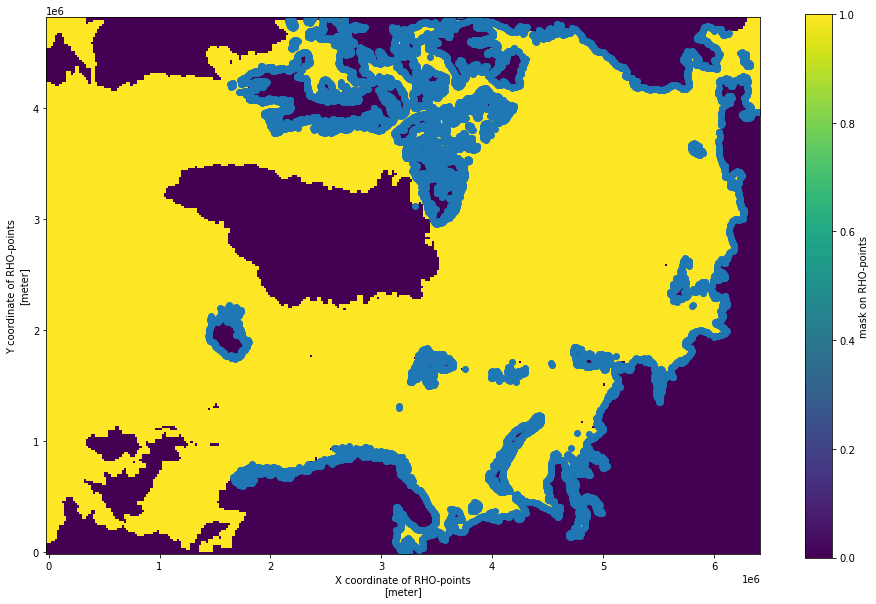

In [11]:
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_gdf = gpd.read_file(radr_pt_shp)

fig, ax = plt.subplots(figsize=(16, 10))
a20_ds["mask_rho"].plot(ax=ax)
radr_pt_gdf.plot(ax=ax)